In [166]:
#!pip install transformers
#!pip install albumentations

In [167]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib
import numpy as np
import matplotlib
matplotlib.use('module://ipympl.backend_nbagg')  # Explicitly set the backend
import matplotlib.pyplot as plt

In [168]:
#!pip install ipympl

In [606]:
import torch
from tqdm.auto import tqdm
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
import os
import matplotlib.pyplot as plt
import albumentations as A

def binary_to_logit_mask(masks):
    C, H, W = masks.shape
    # Create an array of shape (C, H, W) where each channel is its index
    channel_indices = np.arange(C)[:, None, None] + 1
    # Replace False with a sentinel value (e.g., C) to ignore in min()
    masked_indices = np.where(masks, channel_indices, C + 1)
    # Find the minimum index (first True) along axis=0
    logits = np.min(masked_indices, axis=0)
    # Set positions where no mask was True to -1
    logits[logits == C + 1] = 0
    return logits

def unnormalize_image(image,processor):
    from PIL import Image

    if "torch" in str(type(image)):
        image = image.numpy()

    mean = np.array([0,0,0])#processor.image_mean
    std = np.array([1,1,1])#processor.image_std

    unnormalized_image = (image * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
    unnormalized_image *= 255 
    unnormalized_image[unnormalized_image > 255] = 255 
    unnormalized_image[unnormalized_image < 0] = 0
    unnormalized_image = (unnormalized_image).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

def show_points(coords, labels, ax, marker_size=375):
    if labels is not None:
        pos_points = coords[labels==1]
        neg_points = coords[labels==0]
    else:
        pos_points = coords 
        neg_points = coords[labels==0]

    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    #ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


def plot_data(img,anns_semantic,anns_instances=None, n_classes=50, background_class:int=0, points=None):
    if "torch" in str(type(anns_semantic)):
        anns_semantic = anns_semantic.numpy()

    if "torch" in str(type(anns_instances)):
        anns_instances = anns_instances.numpy()

    # 0 is background
    plt.imshow(img)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    if (len(anns_semantic.shape) == 1) and (anns_instances is not None):
        if len(anns_instances.shape) == 3: 
            anns_instances = binary_to_logit_mask(anns_instances)

        anns_semantic = np.stack(
            [
                (anns_instances == 0) * background_class, 
                *[(anns_instances == i+1) * anns_semantic[i] for i in range(len(anns_semantic))]
            ],
            axis=0
        )
        
        anns_semantic = np.sum(anns_semantic,axis=0)
        if background_class != 0:
            anns_semantic += 1
            anns_semantic[anns_semantic == background_class + 1] = 0

        anns_instances *= (anns_semantic != 0)

    elif len(anns_semantic.shape) == 3: 
        anns_semantic = binary_to_logit_mask(anns_semantic)

    mask = np.zeros((anns_semantic.shape[0], anns_semantic.shape[1], 3), dtype=np.uint8)
    # Generate a list of n colors from the `gist_rainbow` colormap
    cmap = plt.colormaps['gist_rainbow']
    colors = (cmap(np.linspace(0, 1, n_classes))[:, :3]*255).astype(np.uint8)  # Convert to RGB

    for id in np.unique(anns_semantic):
        if id == 0:
            continue 

        color_mask = colors[id-1]
        mask[anns_semantic == id] = color_mask

    if anns_instances is not None:
        if len(anns_instances.shape) == 3: 
            anns_instances = binary_to_logit_mask(anns_instances)

        for id in np.unique(anns_instances):
            if id == 0:
                continue 

            import cv2
            contours, _ = cv2.findContours((anns_instances == id).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(mask, contours, -1, (255,255,255), thickness=1) 

    alpha_channel = np.ones((mask.shape[0],mask.shape[1],1),dtype=mask.dtype) * 127
    alpha_channel[(mask[:, :, 0] == 255) & (mask[:, :, 1] == 255) & (mask[:, :, 2] == 255)] = 255 
    alpha_channel[(mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0)] = 0 
    mask = np.concatenate((mask, alpha_channel),axis=2)
    mask[:,:,:3][mask[:,:,3] == 255] = 0
 
    if points is not None:
        show_points(points,None,ax)

    ax.imshow(mask)

    return None

def erode_boolean_mask(mask, kernel_size=3):
    import torch.nn.functional as F
    # mask: (N, H, W) bool
    N, H, W = mask.shape

    # Convert to int (still light, no float math)
    mask = mask.to(torch.uint8)

    # Add channel dim
    mask = mask.unsqueeze(1)  # (N, 1, H, W)

    # Build a kernel of ones
    kernel = torch.ones((1, 1, kernel_size, kernel_size), device=mask.device, dtype=mask.dtype)

    # Do convolution
    filtered = F.conv2d(mask, kernel, stride=1, padding=kernel_size//2)

    # To keep only full hits (i.e., all ones), we threshold
    full = kernel_size * kernel_size
    eroded = (filtered == full)

    return eroded.squeeze(1)  # (N, H, W)

"""
class CocoSAM2Dataset(Dataset):
    def __init__(self, annotation_file, n_classes, root=None, transform=None, kernel_size:int=0):
        if root is None:
            root = os.path.dirname(annotation_file)

        self.img_folder = os.path.normpath(root)
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.kernel_size = kernel_size

        from transformers import Mask2FormerImageProcessor

        processor = Mask2FormerImageProcessor(
            reduce_labels=True,
            ignore_index=0,
            do_resize=False,
            do_rescale=False,
            do_normalize=True
        )

        processor.mean = [0.485, 0.456, 0.406]
        processor.std = [0.229, 0.224, 0.225]

        self.processor = processor
        
        self.transform = transform
        #self.transform = A.Compose([
        #    A.Resize(height=1024, width=1024),  # Ensures image is resized to 1024x1024
        #])
        self.n_classes = n_classes

    def __len__(self):
        return len(self.image_ids)

    def image_id(self,idx):
        return self.image_ids[idx]
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.img_folder, img_info['file_name'])
        image = np.array(Image.open(img_path).convert("RGB"))

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        height, width = img_info['height'], img_info['width']
        
        masks = []
        class_ids = [0]

        for ann in anns:
            rle = ann['segmentation']
            if isinstance(rle, list):
                rle = mask_utils.frPyObjects(rle, height, width)
                rle = mask_utils.merge(rle)

            mask = mask_utils.decode(rle)
            # Ensure we get only binary mask (some RLEs are multi-channel)
            if mask.ndim == 3:
                mask = mask[:, :, 0]

            masks.append(mask)#*ann['id'])
            class_ids.append(ann['category_id'])

        # If no annotations, return dummy
        if len(masks) == 0:
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, image.shape[0], image.shape[1]), dtype=torch.uint8)
            return inputs

        # Stack masks into a single array: (num_instances, H, W)
        masks = np.stack(masks,axis=0)
        masks = binary_to_logit_mask(masks)

        # Optional: apply transforms (e.g. Albumentations or torchvision)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=masks)
            image, masks = transformed['image'], transformed['mask']
            image[image > 255] = 255
            image[image < 0] = 0
        else:
            None

        #pil_image = Image.fromarray(image)

        # Create instance_id to semantic_id mapping
        inst2class = {i: class_ids[i] for i in range(len(class_ids))}

        # Process inputs
        inputs = self.processor([image], [masks], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        inputs = {k: v.squeeze(0) if isinstance(v, torch.Tensor) else v[0] for k, v in inputs.items()}

        class_labels = inputs["class_labels"]
        mask_labels = inputs["mask_labels"]
        
        mask_eroded = mask_labels
        if self.kernel_size > 0:
            mask_eroded = erode_boolean_mask(mask_labels,kernel_size=self.kernel_size)
            not_empty = mask_eroded.sum(dim=(1, 2)) > 0
            mask_eroded = mask_eroded[not_empty==1,:,:]
            mask_labels = mask_labels[not_empty==1,:,:]
            class_labels = class_labels[not_empty==1]

        # Get binary masks and points

        inds = np.arange(mask_labels.shape[0])
        points = []
        #masks = []
        for ind in inds:
            mask = mask_eroded[ind, :, :].to(torch.uint8)  # Convert to uint8
            coords = (mask > 0).nonzero(as_tuple=False)    # Get all (y, x) where mask > 0

            # Calculate centroid
            centroid = coords.float().mean(dim=0)  # (y_centroid, x_centroid)

            # Compute distances to centroid
            dists = torch.norm(coords.float() - centroid.unsqueeze(0), dim=1) ** 2.5  # Euclidean distance
            # Invert distances so that points closer to centroid have higher probability
            # Add small epsilon to avoid division by zero
            eps = 1e-6
            inv_dists = 1.0 / (dists + eps)

            # Normalize to get a probability distribution
            probs = inv_dists / inv_dists.sum()

            # Sample index based on the probabilities
            rand_idx = torch.multinomial(probs, 1)  # Picks 1 index according to probs

            yx = coords[rand_idx].squeeze(0)        # Shape: (2,)
            points.append([[yx[1].item(), yx[0].item()]])  # Append as [x, y]
            
                                    
        inputs = {
            'image':image,#pil_image,
            'pixel_mask':(mask_labels.sum(axis=0) > 0).to(torch.uint8),
            'mask_labels':mask_labels,#np.array(masks),
            'points':torch.Tensor(np.array(points)),
            'class_labels':class_labels
        }

        return inputs
"""

class CocoSAM2Dataset(Dataset):
    def __init__(self, annotation_file, n_classes, root=None, transform=None, kernel_size:int=0):
        if root is None:
            root = os.path.dirname(annotation_file)

        self.img_folder = os.path.normpath(root)
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.ann_ids = list(self.coco.anns.keys())
        self.kernel_size = kernel_size

        from transformers import Mask2FormerImageProcessor

        processor = Mask2FormerImageProcessor(
            reduce_labels=True,
            ignore_index=0,
            do_resize=False,
            do_rescale=False,
            do_normalize=True
        )

        processor.mean = [0.485, 0.456, 0.406]
        processor.std = [0.229, 0.224, 0.225]

        self.processor = processor
        
        self.transform = transform
        #self.transform = A.Compose([
        #    A.Resize(height=1024, width=1024),  # Ensures image is resized to 1024x1024
        #])
        self.n_classes = n_classes

    def __len__(self):
        return len(self.ann_ids)

    def image_id(self,idx):
        return self.image_ids[idx]
        
    def __getitem__(self, idx):
        ann_id = self.ann_ids[idx]
        image_id = self.coco.anns[ann_id]['image_id']
        img_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.img_folder, img_info['file_name'])
        image = np.array(Image.open(img_path).convert("RGB"))

        anns = self.coco.loadAnns([ann_id])

        height, width = img_info['height'], img_info['width']
        
        masks = []
        class_ids = [0]

        for ann in anns:
            rle = ann['segmentation']
            if isinstance(rle, list):
                rle = mask_utils.frPyObjects(rle, height, width)
                rle = mask_utils.merge(rle)

            mask = mask_utils.decode(rle)
            # Ensure we get only binary mask (some RLEs are multi-channel)
            if mask.ndim == 3:
                mask = mask[:, :, 0]

            masks.append(mask)#*ann['id'])
            class_ids.append(ann['category_id'])

        # If no annotations, return dummy
        if len(masks) == 0:
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, image.shape[0], image.shape[1]), dtype=torch.uint8)
            return inputs

        # Stack masks into a single array: (num_instances, H, W)

        masks = np.stack(masks,axis=0)
        masks = binary_to_logit_mask(masks)

        # Optional: apply transforms (e.g. Albumentations or torchvision)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=masks)
            image, masks = transformed['image'], transformed['mask']
            image[image > 255] = 255
            image[image < 0] = 0
        else:
            None

        #pil_image = Image.fromarray(image)

        # Create instance_id to semantic_id mapping
        inst2class = {i: class_ids[i] for i in range(len(class_ids))}
        # Process inputs
        inputs = self.processor([image], [masks], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        inputs = {k: v.squeeze(0) if isinstance(v, torch.Tensor) else v[0] for k, v in inputs.items()}
        if len(anns) == 1: 
            inputs['mask_labels'] = torch.tensor(masks.astype(np.float32)).unsqueeze(axis=0)
            inputs['class_labels'] = torch.tensor([inst2class[1]]) 

        class_labels = inputs["class_labels"]
        mask_labels = inputs["mask_labels"]
        
        mask_eroded = mask_labels
        if self.kernel_size > 0:
            mask_eroded = erode_boolean_mask(mask_labels,kernel_size=self.kernel_size)
            not_empty = mask_eroded.sum(dim=(1, 2)) > 0
            mask_eroded = mask_eroded[not_empty==1,:,:]
            mask_labels = mask_labels[not_empty==1,:,:]
            class_labels = class_labels[not_empty==1]

        # Get binary masks and points

        inds = np.arange(mask_labels.shape[0])
        points = []
        #masks = []
        for ind in inds:
            mask = mask_eroded[ind, :, :].to(torch.uint8)  # Convert to uint8
            coords = (mask > 0).nonzero(as_tuple=False)    # Get all (y, x) where mask > 0
            if coords.shape[0] == 0:
                continue  # Skip empty masks

            # Calculate centroid
            centroid = coords.float().mean(dim=0)  # (y_centroid, x_centroid)

            # Compute distances to centroid
            dists = torch.norm(coords.float() - centroid.unsqueeze(0), dim=1) ** 2.5  # Euclidean distance
            # Invert distances so that points closer to centroid have higher probability
            # Add small epsilon to avoid division by zero
            eps = 1e-6
            inv_dists = 1.0 / (dists + eps)

            # Normalize to get a probability distribution
            probs = inv_dists / inv_dists.sum()

            # Sample index based on the probabilities
            rand_idx = torch.multinomial(probs, 1)  # Picks 1 index according to probs

            yx = coords[rand_idx].squeeze(0)        # Shape: (2,)
            points.append([[yx[1].item(), yx[0].item()]])  # Append as [x, y]
            
                                    
        inputs = {
            'image':image,#pil_image,
            'pixel_mask':(mask_labels.sum(axis=0) > 0).to(torch.uint8),
            'mask_labels':mask_labels,#np.array(masks),
            'points':torch.Tensor(np.array(points)),
            'class_labels':class_labels
        }

        return inputs

In [607]:
np.random.seed(42)

In [608]:
orig_checkpoint_path = "/home/caminos-7/python_envs/instance_segmentation/segment-anything-2/checkpoints/sam2.1_hiera_tiny.pt"#"/home/caminos-7/python_envs/geoSAM2/segment-anything-2/checkpoints"
ckpt_fine_tune = "/home/caminos-7/MiguelU/instance_segmentation/SAM2/checkpoints/checkpoint.pt"
annotation_file = "/home/caminos-7/MiguelU/instance_segmentation/dataset/test_annotations_coco_agg.json"

In [609]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [610]:
import sam2.build_sam
model_name = "sam2.1-hiera-tiny"
config_file,ckpt_file = sam2.build_sam.HF_MODEL_ID_TO_FILENAMES['facebook/' + model_name]
#config_file = "configs/sam2.1/config.yaml"
#ckpt_path = orig_checkpoint_path + "/" + ckpt_file
ckpt_path = ckpt_fine_tune 
ckpt_path

'/home/caminos-7/MiguelU/instance_segmentation/SAM2/checkpoints/checkpoint.pt'

In [611]:
import os
print("ckpt_path:", ckpt_path)
print("Exists:", os.path.exists(ckpt_path))

ckpt_path: /home/caminos-7/MiguelU/instance_segmentation/SAM2/checkpoints/checkpoint.pt
Exists: True


In [612]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [613]:
model = build_sam2('configs/sam2.1/sam2.1_hiera_t.yaml', 
ckpt_path, device=device)

In [614]:
predictor = SAM2ImagePredictor(model)

In [615]:
test_dataset = CocoSAM2Dataset(annotation_file=annotation_file,n_classes=1,kernel_size=0)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [616]:
inputs = test_dataset[0]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

pixel_mask torch.Size([512, 512])
mask_labels torch.Size([1, 512, 512])
points torch.Size([1, 1, 2])
class_labels torch.Size([1])


In [617]:
np.unique(inputs["class_labels"])

array([1])

In [618]:
from torch.utils.data import DataLoader 

def collate_fn(batch):
    images = [example["image"] for example in batch]
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"][:,np.newaxis] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    points = [example["points"] for example in batch]
    return {"images": images, "pixel_masks": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels, "points":points}

test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False, collate_fn=collate_fn)

In [619]:
test_batch = next(iter(test_dataloader))
for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

images 6
pixel_masks torch.Size([6, 512, 512])
class_labels 6
mask_labels 6
points 6


In [620]:
from evaluation import Evaluator
e = Evaluator(
    dimension=2,
    allow_overlap=True, # Allow overlapping instance masks in binary inputs
    match_method='hungarian', 
    image_average=False # False computes average over all instances True computes average metric over all images
)

In [621]:
def evaluate(predictor,test_dataloader,evaluator):
    import copy
    evaluator = copy.deepcopy(evaluator)
    test_batch = next(iter(test_dataloader))
    loss = 0 
    n_samples = 0
    for test_batch in test_dataloader:
        with torch.no_grad():
            try:
                predictor.set_image_batch(test_batch['images'])
                masks_batch, scores_batch, _ = predictor.predict_batch(
                    test_batch['points'],
                    test_batch['class_labels'],
                    box_batch=None,
                    multimask_output=False
                )
            except:
                continue

        n_samples += len(masks_batch)
        outputs = None
        for i in range(len(masks_batch)):
            if len(masks_batch[i].shape) == 3: 
                anns_instances = masks_batch[i][0,:,:] == 1
            else:
                anns_instances = masks_batch[i][0,0,:,:] == 1

            anns_instances_gt = test_batch["mask_labels"][i].numpy()
            evaluator.add_example(anns_instances, anns_instances_gt,verbose=False) 

    aji = evaluator.AJI()
    sbd = evaluator.SBD()
    pq = evaluator.PQ()
    mAP = evaluator.mAP()
    sAP = evaluator.sortedAP()
    #print("Loss: ", loss / n_samples)

    return {'AJI':aji,'SBD':sbd,'PQ':pq,'mAP':mAP,'sAP':sAP}#,'loss':loss/n_samples}

In [622]:
eval_result = evaluate(predictor,test_dataloader,e)

aggregatedJaccard: 0.6060318308193534, image average: False
SBD: 0.7994153054115161, image average: False
PQ: 0.6524789500223183, image average: False
mAP: 0.4159236434313455, image average: False
sortedAP: 0.6103986774277883, image average: False


In [623]:
with torch.no_grad():
        predictor.set_image_batch(test_batch['images'])
        masks_batch, scores_batch, _ = predictor.predict_batch(
                test_batch['points'],
                test_batch['class_labels'],
                box_batch=None,
                multimask_output=False
        ) 

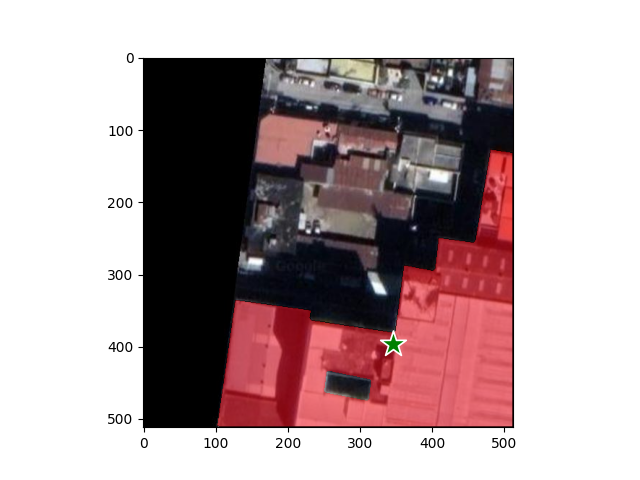

In [624]:
batch_index = 0
img = test_batch["images"][batch_index] 
#img = unnormalize_image(img,processor=dataset.processor)
anns_semantic = test_batch["class_labels"][batch_index]
anns_instances = test_batch["mask_labels"][batch_index]
plot_data(img,anns_semantic=anns_semantic[:,0],anns_instances=anns_instances,background_class=255,points = test_batch['points'][batch_index][:,0,:])
plt.show()

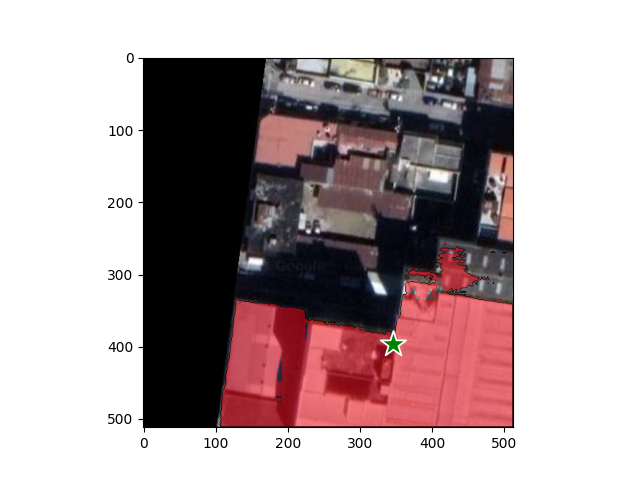

In [625]:
# you can pass them to processor for postprocessing
batch_index = 0
img = test_batch["images"][batch_index] 
#img = unnormalize_image(img,processor=processor)

#anns_instances = [masks_batch[batch_index][i,0,:,:] == 1 for i in range(masks_batch[batch_index].shape[0])]
anns_instances = [masks_batch[batch_index][i,:,:] == 1 for i in range(masks_batch[batch_index].shape[0])]
anns_instances = np.stack(anns_instances,axis=0)
anns_instances = binary_to_logit_mask(anns_instances)
anns_semantic = np.ones(masks_batch[batch_index].shape[0],dtype=int)
plot_data(img,anns_instances=anns_instances,anns_semantic=anns_semantic,background_class=255,points=test_batch['points'][batch_index][:,0,:])
plt.show()

In [157]:
predictor.set_image_batch([test_batch['images'][0]])

In [158]:
def on_click(event):
    # Get the coordinates of the click (in pixels)
    x, y = event.xdata, event.ydata
    if x is not None and y is not None:  # Ensure the click was within the image
        coordinates.append((x, y))
        print(f"Coordinates captured: x={x}, y={y}")
        # Optionally, add a marker on the image for feedback
        ax.plot(x, y, 'ro')  # Plot red dot where the user clicked
        plt.draw()

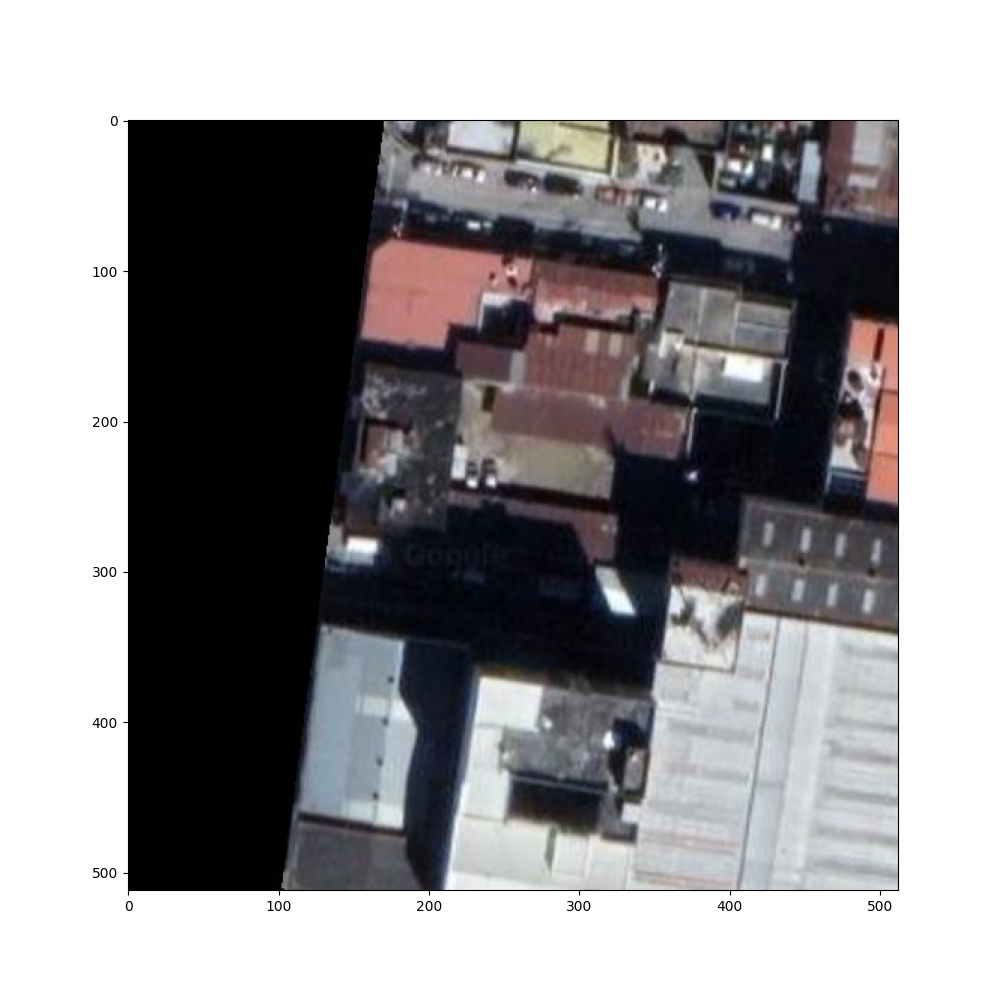

In [159]:
coordinates = []
# Create a figure and display the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.axis('on')

# Connect the event handler to the click event
fig.canvas.mpl_connect('button_press_event', on_click)

# Show the plot and allow the user to interact
plt.show()

In [130]:
input_points = np.array(coordinates)
input_labels = np.ones(input_points.shape[0],dtype=int)
input_points

array([[402.99524148, 400.01298701],
       [194.20563109, 109.43636364],
       [485.44718953,  14.35064935]])

In [131]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [132]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [133]:
masks.shape

(3, 512, 512)

In [134]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

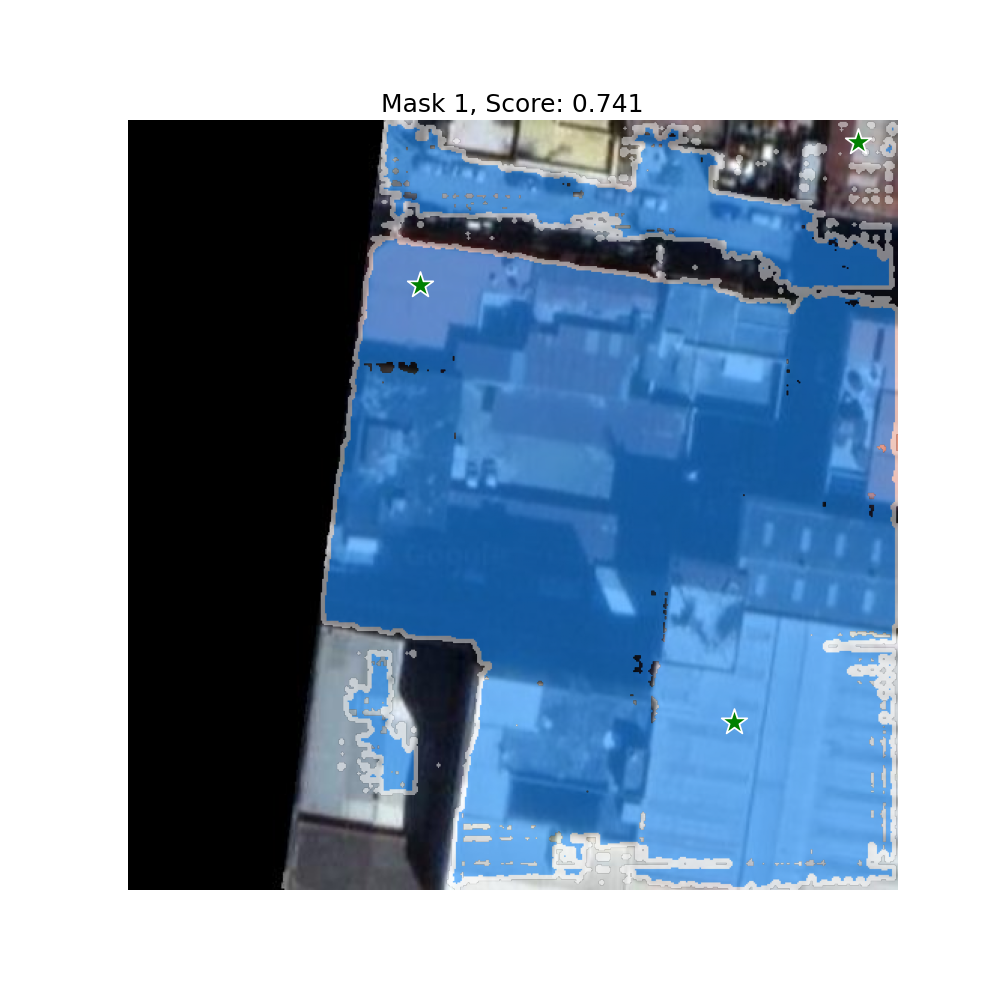

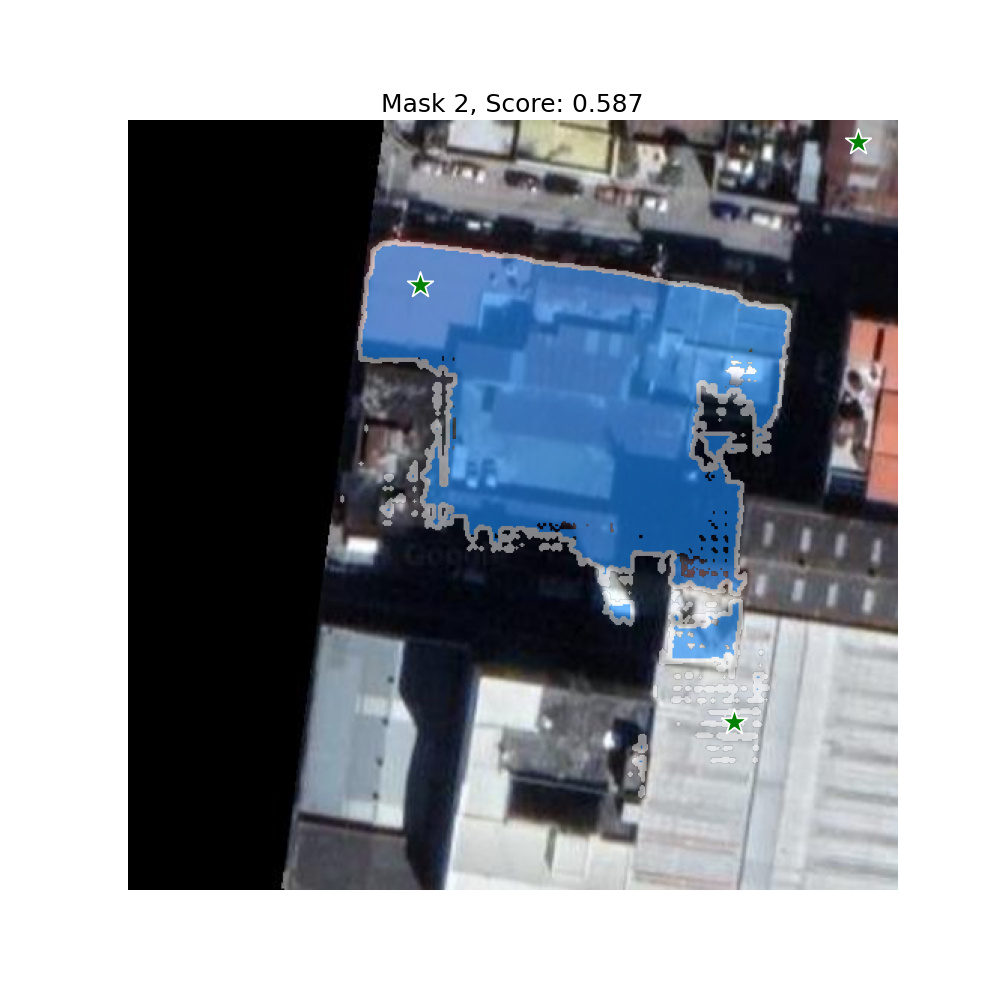

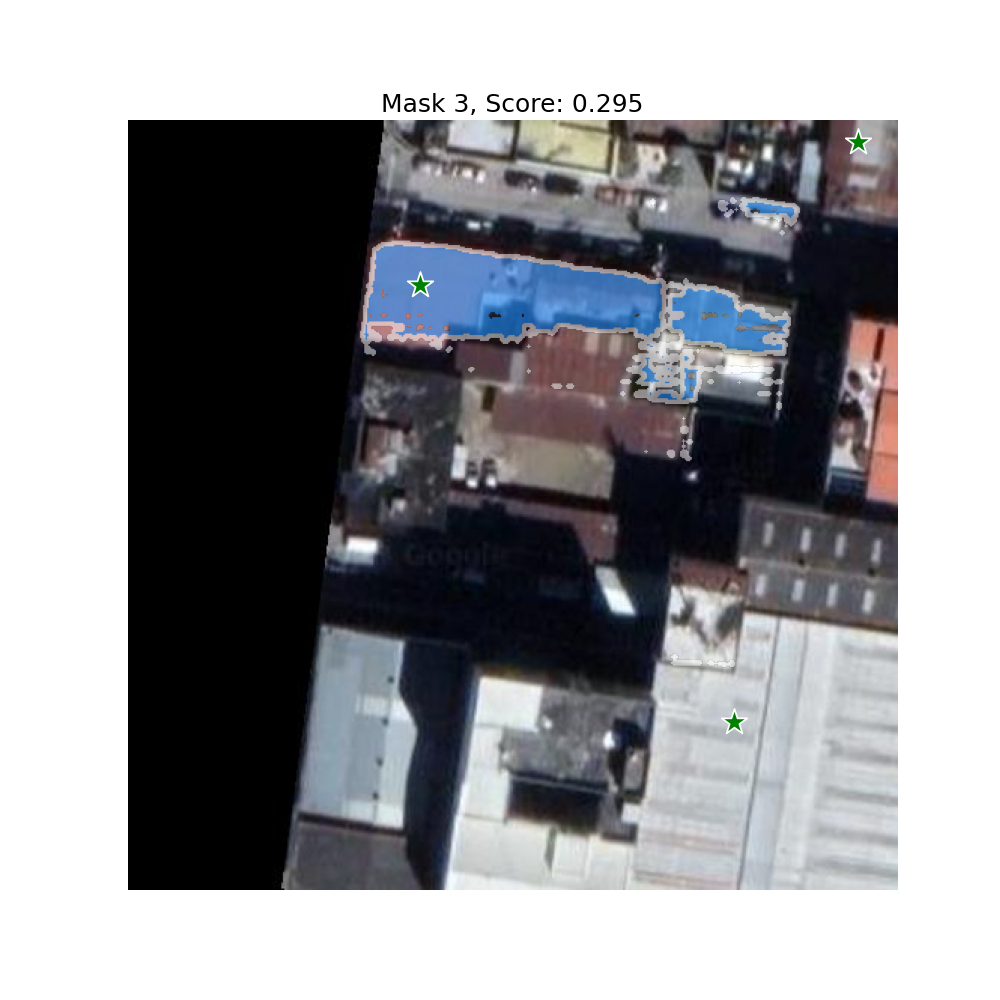

In [135]:
show_masks(img, masks, scores, point_coords=input_points, input_labels=input_labels, borders=True)